In [2]:
#Librairie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, Activation
import optuna
import tensorflow as tf
from optuna.integration import TFKerasPruningCallback



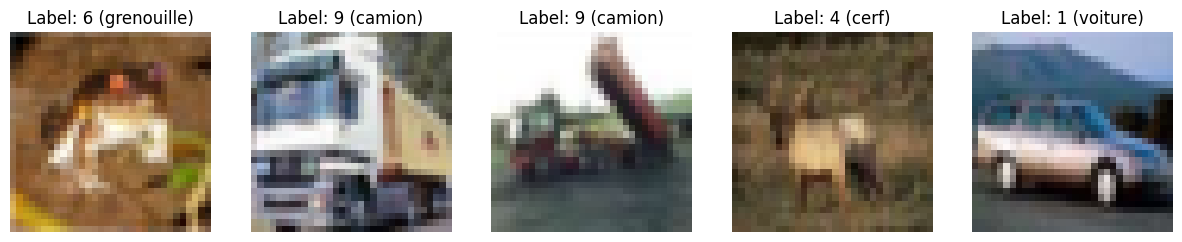

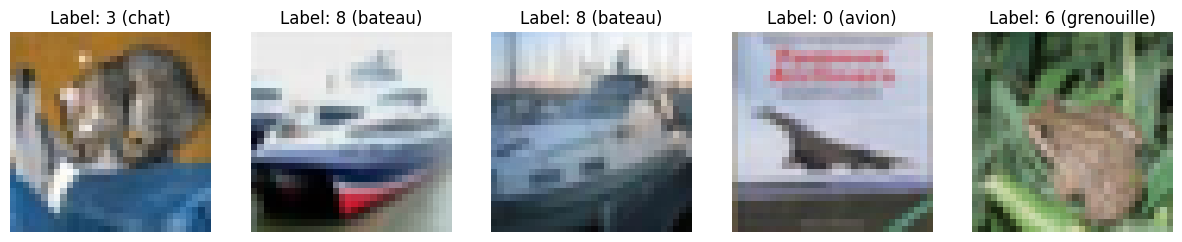

In [ ]:
#Importation Dataset CIFAR-10
#Obligatoire
import tensorflow as tf

(x_train_t, y_train_t), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

#Split le data set en train et en validation (pour les CNN)

N_train_t = np.shape(x_train_t)[0]
N_train = round(0.8*N_train_t) # 80% pour le train et 20% pour la validation
x_train,y_train = x_train_t[0:N_train],y_train_t[0:N_train]
x_val,y_val = x_train_t[N_train:],y_train_t[N_train:]


#Normalisation des images

x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0


cifar10_labels = ['avion', 'voiture', 'oiseau', 'chat', 'cerf', 'chien', 'grenouille', 'cheval', 'bateau', 'camion']

plt.figure(figsize=(15,3)) 
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(x_train[i])
    label_index = y_train[i][0] if isinstance(y_train[i], np.ndarray) else y_train[i]
    plt.title(f"Label: {label_index} ({cifar10_labels[label_index]})")
    plt.axis('off')
plt.show()

plt.figure(figsize=(15,3)) 
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(x_test[i])
    label_index = y_test[i][0] if isinstance(y_test[i], np.ndarray) else y_test[i]
    plt.title(f"Label: {label_index} ({cifar10_labels[label_index]})")
    plt.axis('off')
plt.show()




In [ ]:
#Algo de ML : Decision Tree 

x_train_flat = x_train_t.reshape((x_train_t.shape[0], -1))
x_test_flat = x_test.reshape((x_test.shape[0], -1))

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_flat)
x_test_scaled = scaler.transform(x_test_flat)

arbre = DecisionTreeClassifier(max_depth=10, criterion='gini', min_samples_split=20, random_state=44)
arbre.fit(x_train_scaled, y_train_t.ravel())
'''
param_grid = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 10, 20],
    'criterion': ['gini', 'entropy']
}

# GridSearch avec validation croisée 3-fold
grid_search = GridSearchCV(arbre, param_grid, cv=3)
grid_search.fit(x_train_scaled, y_train_t.ravel())
'''
y_pred = arbre.predict(x_test_scaled)
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')  # Calcul du rappel
print(f"Précision de l'arbre de décision sur CIFAR-10 : {acc:.2f}")
print(f"Rappel de l'arbre de décision sur CIFAR-10 : {recall:.2f}")

In [ ]:
#Foret Aleatoire 
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraînement du modèle
rf.fit(x_train_scaled, y_train_t.ravel())

# Prédiction et évaluation
y_pred = rf.predict(x_test_scaled)
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')  # Calcul du rappel
print(f"Précision de la forêt aléatoire sur CIFAR-10 : {acc:.2f}")
print(f"Rappel de la forêt aléatoire sur CIFAR-10 : {recall:.2f}")

Précision de la forêt aléatoire sur CIFAR-10 : 0.10
Rappel de la forêt aléatoire sur CIFAR-10 : 0.10


In [ ]:
#3 CNN aux architectures différentes
#Obligatoire
# Redimensionner les images (32x32 -> 32x32x1) pour la convolution
x_train = x_train.reshape(-1, 32, 32, 3)
x_val = x_val.reshape(-1, 32, 32, 3)
x_test = x_test.reshape(-1, 32, 32, 3)
# Encodage One-Hot des labels
y_train_c = to_categorical(y_train, 10)
y_val_c = to_categorical(y_val, 10)
y_test_c = to_categorical(y_test, 10)

In [ ]:

# Optuna pour déterminer le meilleur combo epochs/batch size

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
def create_classic_cnn_model(input_shape, learning_rate):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax') 
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy','recall']
    )
    return model

def objective_cnn_classique(trial):
    # Hyperparamètres testés
    epochs = trial.suggest_int('epochs', 10, 30)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    tf.keras.backend.clear_session()

    model = create_classic_cnn_model(input_shape=x_train.shape[1:], learning_rate=learning_rate)

    # Callbacks
    early_stopping_optuna = EarlyStopping(
        monitor='val_accuracy', 
        patience=7,         
        restore_best_weights=True,
        mode='max'          
    )
    pruning_callback = TFKerasPruningCallback(trial, 'val_accuracy')

    print(f"\nTrial {trial.number}: epochs={epochs}, batch_size={batch_size}, lr={learning_rate:.5f}")

    # Entraîner le modèle
    history = model.fit(
        x_train, y_train_c,
        validation_data=(x_val, y_val_c),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping_optuna, pruning_callback],
        verbose=0 
    )

    
    val_accuracy = max(history.history['val_accuracy']) 
    
   
    if not history.history['val_accuracy']:
        return 0.0 

    return val_accuracy


# Le pruner aide à arrêter les essais non prometteurs plus tôt pr éviter que ce soit trop long
study_cnn_classique = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study_cnn_classique.optimize(objective_cnn_classique, n_trials=20) 

print("\nOptimisation terminée.")
print("Meilleurs hyperparamètres trouvés pour le CNN classique: ", study_cnn_classique.best_params)
print("Meilleure val_accuracy obtenue : ", study_cnn_classique.best_value)


best_params_cnn_classique = study_cnn_classique.best_params


In [ ]:
#CNN classique (comme dans le TD)
model = Sequential([
Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)), # Couche Conv
MaxPooling2D(2,2), # Max Pooling
Conv2D(64, (3,3), activation='relu'), # Deuxième Couche Conv
MaxPooling2D(2,2),
Flatten(), # Aplatit les données
Dense(128, activation='relu'), # Couche Fully Connected
Dense(10, activation='softmax') # Couche de sortie (10 classes)
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','recall'])
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

C:\Users\simon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,722 (1.20 MB)

 Trainable params: 315,722 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
#CNN un peu plus complexe (une couche de convolution en + et ajout de dropout)

model_2 = Sequential([
    Conv2D(64, (3,3), padding='same', input_shape=(32,32,3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    Conv2D(128, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.4),

    Conv2D(256, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(512), 
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'recall'])
model_2.summary()

C:\Users\simon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,477,450 (9.45 MB)

 Trainable params: 2,475,530 (9.44 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
#Modèle basé sur le MCDNN https://arxiv.org/pdf/1202.2745v1 
#Si ça overfit rajoute du dropout

model_3 = Sequential([
    Conv2D(300, (3, 3), padding='same', input_shape=(32, 32, 3)), 
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  

    Conv2D(300, (2, 2), padding='same'), 
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(300, (2, 2), padding='same'), 
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
   

    Conv2D(300, (2, 2), padding='same'), 
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25), 

    Flatten(), 
    Dense(300), 
    BatchNormalization(),
    Activation('relu'),
    

    Dense(100), 
    BatchNormalization(),
    Activation('relu'),
    

    Dense(10, activation='softmax')  
])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','recall'])
model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 30, 30, 300)    │         8,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 300)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 15, 15, 300)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 300)    │       360,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 300)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 300)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 300)      │       360,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 3, 3, 300)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 2, 2, 300)      │       360,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 1, 300)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 1, 300)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,210,710 (4.62 MB)

 Trainable params: 1,210,710 (4.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.3338 - loss: 1.8217 - recall: 0.0850 - val_accuracy: 0.5383 - val_loss: 1.3176 - val_recall: 0.3043
Epoch 2/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.5511 - loss: 1.2647 - recall: 0.3556 - val_accuracy: 0.5892 - val_loss: 1.1861 - val_recall: 0.4341
Epoch 3/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step - accuracy: 0.6169 - loss: 1.0941 - recall: 0.4566 - val_accuracy: 0.6349 - val_loss: 1.0581 - val_recall: 0.4906
Epoch 4/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.6550 - loss: 0.9884 - recall: 0.5204 - val_accuracy: 0.6333 - val_loss: 1.0527 - val_recall: 0.5114
Epoch 5/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.6833 - loss: 0.9083 - recall: 0.5683 - val_accuracy: 0.6662 - val_loss: 0.9646 - val_recall: 0.5554
Epoch 6/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.7087 - loss: 0.8345 - recall: 0.6098 - val_accuracy: 0.6844 - val_loss: 0.9106 - val_recall:

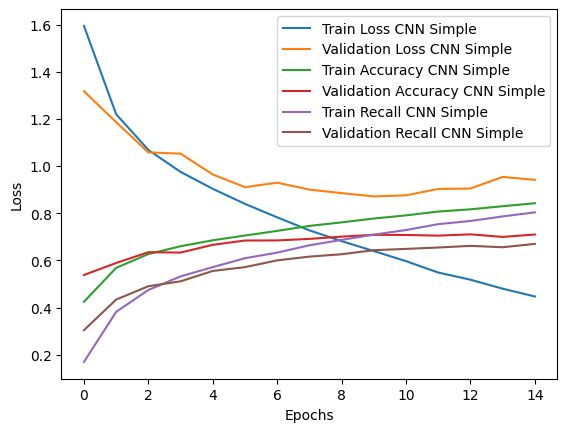

In [7]:
# Entraînement du 1er model
history_1 = model.fit(
    x_train, y_train_c,
    validation_data=(x_val, y_val_c),
    epochs=22,
    batch_size=64,
    callbacks=[early_stopping]
)

plt.plot(history_1.history['loss'], label='Train Loss CNN Simple')
plt.plot(history_1.history['val_loss'], label='Validation Loss CNN Simple')
plt.plot(history_1.history['accuracy'], label='Train Accuracy CNN Simple')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy CNN Simple')
plt.plot(history_1.history['recall'], label='Train Recall CNN Simple')
plt.plot(history_1.history['val_recall'], label='Validation Recall CNN Simple')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


In [ ]:
# Entraînement model_2
history_intermediate = model_2.fit(
    x_train, y_train_c,
    validation_data=(x_val, y_val_c),
    epochs=22,
    batch_size=64,
    callbacks=[early_stopping]
)
plt.plot(history_intermediate.history['loss'], label='Train Loss CNN Inter')
plt.plot(history_intermediate.history['val_loss'], label='Validation Loss CNN Inter')
plt.plot(history_intermediate.history['accuracy'], label='Train Accuracy CNN Inter')
plt.plot(history_intermediate.history['val_accuracy'], label='Validation Accuracy CNN Inter')
plt.plot(history_intermediate.history['recall'], label='Train Recall CNN Inter')
plt.plot(history_intermediate.history['val_recall'], label='Validation Recall CNN Inter')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Epoch 1/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 209s 331ms/step - accuracy: 0.4025 - loss: 1.7713 - recall: 0.2601 - val_accuracy: 0.4077 - val_loss: 2.0324 - val_recall: 0.2829
Epoch 2/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 216s 346ms/step - accuracy: 0.6168 - loss: 1.0750 - recall: 0.4905 - val_accuracy: 0.6029 - val_loss: 1.1796 - val_recall: 0.5128
Epoch 3/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 227s 363ms/step - accuracy: 0.6774 - loss: 0.9031 - recall: 0.5717 - val_accuracy: 0.5101 - val_loss: 1.6885 - val_recall: 0.4390
Epoch 4/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 258s 412ms/step - accuracy: 0.7136 - loss: 0.8137 - recall: 0.6214 - val_accuracy: 0.6037 - val_loss: 1.1792 - val_recall: 0.5285
Epoch 5/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 263s 421ms/step - accuracy: 0.7448 - loss: 0.7301 - recall: 0.6656 - val_accuracy: 0.6179 - val_loss: 1.1563 - val_recall: 0.5737
Epoch 6/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 367s 587ms/step - accuracy: 0.7616 - loss: 0.6731 - recall: 0.6912 - val_accuracy: 0.7274 - val_loss: 0.7933 -

In [ ]:

# Entraînement du MCDNN
history_deep = model_3.fit(
    x_train, y_train_c,
    validation_data=(x_val, y_val_c),
    epochs=22,
    batch_size=64,
    callbacks=[early_stopping]
)
plt.plot(history_deep.history['loss'], label='Train Loss MCDNN')
plt.plot(history_deep.history['val_loss'], label='Validation Loss MCDNN')
plt.plot(history_deep.history['accuracy'], label='Train Accuracy MCDNN')
plt.plot(history_deep.history['val_accuracy'], label='Validation Accuracy MCDNN')
plt.plot(history_deep.history['recall'], label='Train Recall MCDNN')
plt.plot(history_deep.history['val_recall'], label='Train Recall MCDNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

NameError: name 'model_3' is not defined

In [ ]:
#Evaluation du 1er modèle
model_names_single = ["CNN Classique (model)"]
models_to_evaluate_single = [model] 

results_single = []

print("Évaluation du modèle CNN Classique en cours...")

for i, current_model in enumerate(models_to_evaluate_single):
    model_name = model_names_single[i]
    print(f"Évaluation de : {model_name}")

    train_loss, train_accuracy, train_recall = current_model.evaluate(x_train, y_train_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Train",
        "Loss": f"{train_loss:.4f}",
        "Accuracy": f"{train_accuracy:.4f}",
        "Recall": f"{train_recall:.4f}"
    })

    val_loss, val_accuracy, val_recall = current_model.evaluate(x_val, y_val_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Validation",
        "Loss": f"{val_loss:.4f}",
        "Accuracy": f"{val_accuracy:.4f}",
        "Recall": f"{val_recall:.4f}"
    })


    test_loss, test_accuracy, test_recall = current_model.evaluate(x_test, y_test_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Test",
        "Loss": f"{test_loss:.4f}",
        "Accuracy": f"{test_accuracy:.4f}",
        "Recall": f"{test_recall:.4f}"
    })


df_results_single = pd.DataFrame(results_single)

print("\n\nTableau Récapitulatif des Performances (CNN Classique):\n")
print(df_results_single.to_markdown(index=False))



Évaluation du modèle CNN Classique en cours...
Évaluation de : CNN Classique (model)


Tableau Récapitulatif des Performances (CNN Classique):

| Modèle                | Set        |   Loss |   Accuracy |   Recall |
|:----------------------|:-----------|-------:|-----------:|---------:|
| CNN Classique (model) | Train      | 0.4982 |     0.8347 |   0.7674 |
| CNN Classique (model) | Validation | 0.8714 |     0.7086 |   0.6434 |
| CNN Classique (model) | Test       | 0.8893 |     0.7042 |   0.6395 |


In [10]:
#Evaluation du 2ème modèle
model_names_single = ["CNN Intermédiaire"]
models_to_evaluate_single = [model_2] 

results_single = []

print("Évaluation du modèle CNN Classique en cours...")

for i, current_model in enumerate(models_to_evaluate_single):
    model_name = model_names_single[i]
    print(f"Évaluation de : {model_name}")

    
    train_loss, train_accuracy, train_recall = current_model.evaluate(x_train, y_train_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Train",
        "Loss": f"{train_loss:.4f}",
        "Accuracy": f"{train_accuracy:.4f}",
        "Recall": f"{train_recall:.4f}"
    })

    
    val_loss, val_accuracy, val_recall = current_model.evaluate(x_val, y_val_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Validation",
        "Loss": f"{val_loss:.4f}",
        "Accuracy": f"{val_accuracy:.4f}",
        "Recall": f"{val_recall:.4f}"
    })

    
    test_loss, test_accuracy, test_recall = current_model.evaluate(x_test, y_test_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Test",
        "Loss": f"{test_loss:.4f}",
        "Accuracy": f"{test_accuracy:.4f}",
        "Recall": f"{test_recall:.4f}"
    })


df_results_single = pd.DataFrame(results_single)

print("\n\nTableau Récapitulatif des Performances (CNN Intermédiaire):\n")
print(df_results_single.to_markdown(index=False))



Évaluation du modèle CNN Classique en cours...
Évaluation de : CNN Intermédiaire


Tableau Récapitulatif des Performances (CNN Intermédiaire):

| Modèle            | Set        |   Loss |   Accuracy |   Recall |
|:------------------|:-----------|-------:|-----------:|---------:|
| CNN Intermédiaire | Train      | 0.5245 |     0.8256 |   0.7406 |
| CNN Intermédiaire | Validation | 0.789  |     0.7243 |   0.6455 |
| CNN Intermédiaire | Test       | 0.8179 |     0.717  |   0.635  |


In [ ]:
#Evaluation du 3ème modèle
model_names_single = ["MCDNN"]
models_to_evaluate_single = [model_3] 

results_single = []

print("Évaluation du modèle CNN Classique en cours...")

for i, current_model in enumerate(models_to_evaluate_single):
    model_name = model_names_single[i]
    print(f"Évaluation de : {model_name}")

    
    train_loss, train_accuracy, train_recall = current_model.evaluate(x_train, y_train_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Train",
        "Loss": f"{train_loss:.4f}",
        "Accuracy": f"{train_accuracy:.4f}",
        "Recall": f"{train_recall:.4f}"
    })

    
    val_loss, val_accuracy, val_recall = current_model.evaluate(x_val, y_val_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Validation",
        "Loss": f"{val_loss:.4f}",
        "Accuracy": f"{val_accuracy:.4f}",
        "Recall": f"{val_recall:.4f}"
    })

    
    test_loss, test_accuracy, test_recall = current_model.evaluate(x_test, y_test_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Test",
        "Loss": f"{test_loss:.4f}",
        "Accuracy": f"{test_accuracy:.4f}",
        "Recall": f"{test_recall:.4f}"
    })


df_results_single = pd.DataFrame(results_single)

print("\n\nTableau Récapitulatif des Performances (MCDNN):\n")
print(df_results_single.to_markdown(index=False))



In [ ]:
#CNN hybride avec ResNet + SVM (entrainement, )
from sklearn.svm import SVC
from tensorflow.keras.applications import ResNet50V2
#from tensorflow.image import resize pas besoin de resize car les images sont déjà en 32x32 avec ResNet

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

base_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
for layer in base_model.layers:
    layer.trainable = False


x_train_extraite = base_model.predict(x_train, verbose=1)
x_test_extraite= base_model.predict(x_test, verbose=1)


features_train_flat = x_train_extraite.reshape(x_train_extraite.shape[0], -1)
features_test_flat = x_test_extraite.reshape(x_test_extraite.shape[0], -1)

scaler = StandardScaler()
features_train_flat = scaler.fit_transform(features_train_flat)
features_test_flat = scaler.transform(features_test_flat)

print("Entraînement du SVM...")
svm= SVC(kernel='linear', C=1, random_state=42)
svm.fit(features_train_flat, y_train.ravel())

y_pred_test = svm.predict(features_test_flat)
y_true_test = y_test.ravel() # Utiliser y_test (10k échantillons)

# Prédictions sur l'ensemble d'entraînement
print("Prédictions sur les données d'entraînement...")
y_pred_train = svm.predict(features_train_flat)
y_true_train = y_train.ravel() # Utiliser y_train (50k échantillons)

# Calculer les métriques pour l'ensemble de test
acc_test = accuracy_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test, average='macro')

# Calculer les métriques pour l'ensemble d'entraînement
acc_train = accuracy_score(y_true_train, y_pred_train)
recall_train = recall_score(y_true_train, y_pred_train, average='macro')

# Stocker les résultats
results_hybrid = []
results_hybrid.append({
    "Modèle": "ResNet50V2+SVM",
    "Set": "Train",
    "Accuracy": f"{acc_train:.4f}",
    "Recall": f"{recall_train:.4f}"
})
results_hybrid.append({
    "Modèle": "ResNet50V2+SVM",
    "Set": "Test",
    "Accuracy": f"{acc_test:.4f}",
    "Recall": f"{recall_test:.4f}"
})

# Créer un DataFrame et afficher le tableau
df_results_hybrid = pd.DataFrame(results_hybrid)
print("\n\nTableau Récapitulatif des Performances (ResNet50V2+SVM):\n")
print(df_results_hybrid.to_markdown(index=False))

# Afficher la matrice de confusion pour l'ensemble de test
print("\nMatrice de confusion (Ensemble de Test):")
print(confusion_matrix(y_true_test, y_pred_test))


    

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 467s 295ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 102s 326ms/step
Entraînement du SVM...
